# AICE ASOO 대비 와인 등급 분류모델 개선실험

- 최근 치뤘던 AICE 자격증 대비 연습문제를 좀 더 개선해보고자 합니다.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
wine = pd.read_csv('../data/csv/wine_red.csv', sep=';')

In [5]:
wine.shape

(1599, 12)

In [6]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
wine['quality'].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [13]:
num_columns = wine.select_dtypes(include='number').columns
num_columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

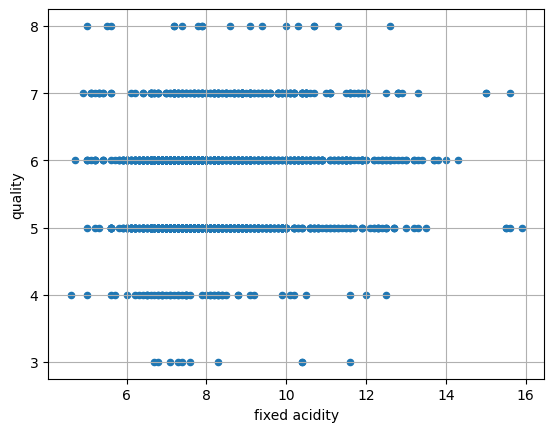

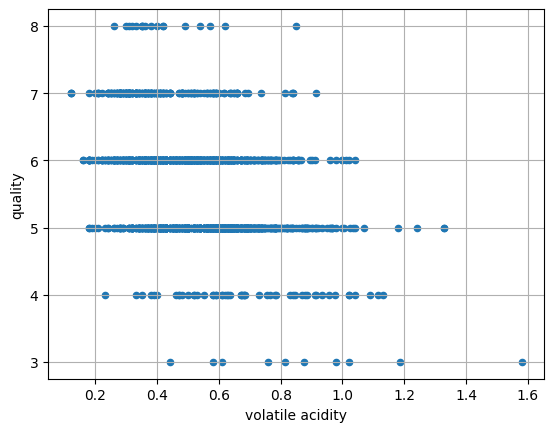

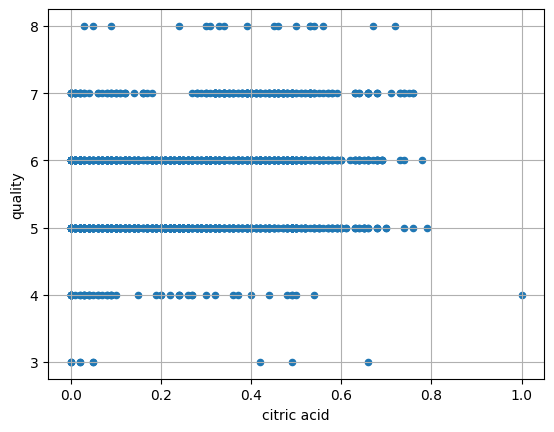

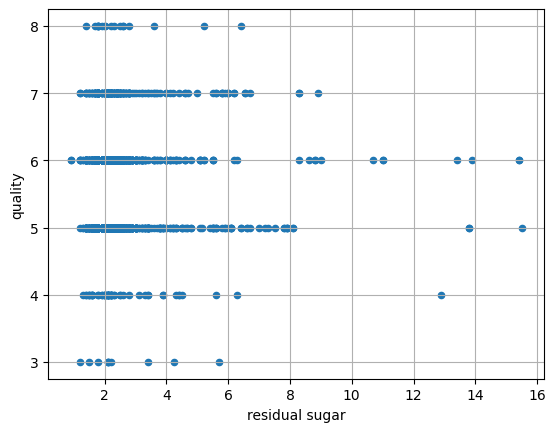

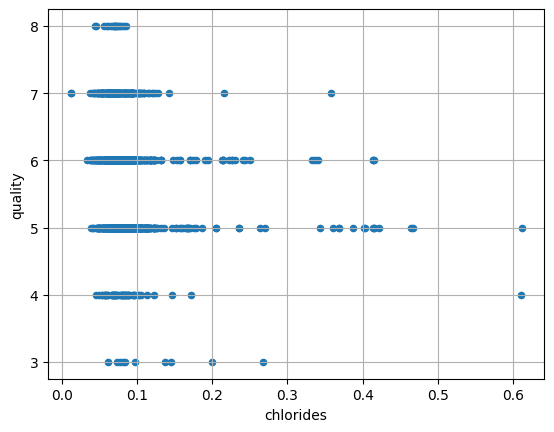

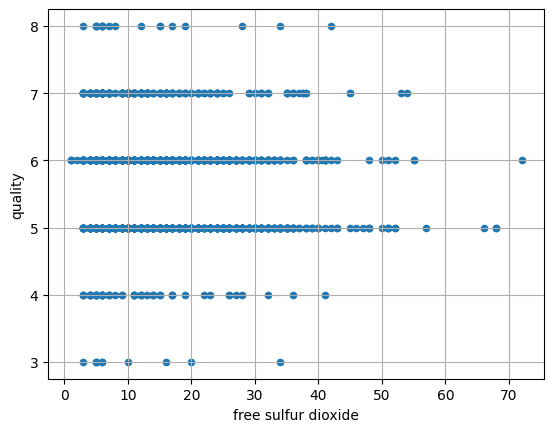

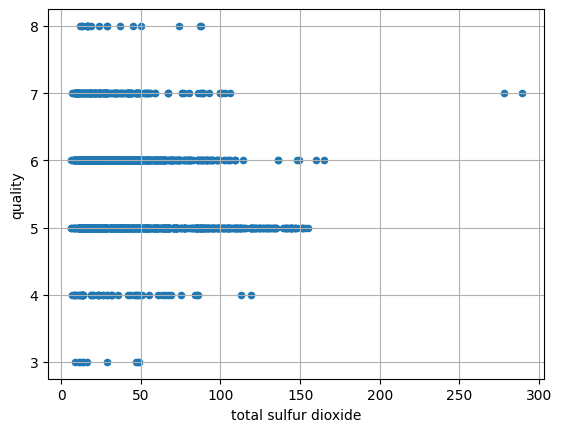

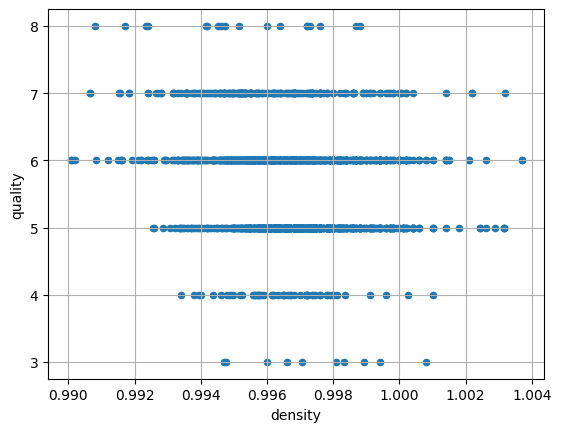

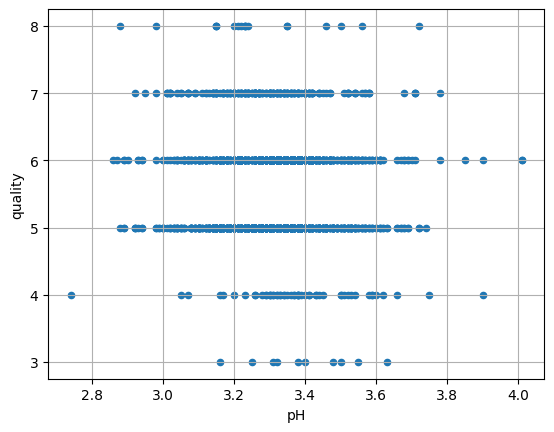

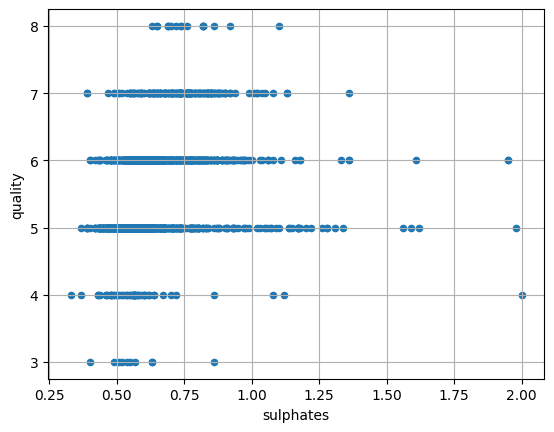

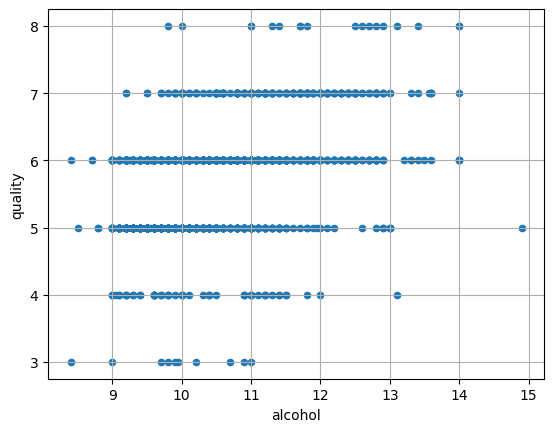

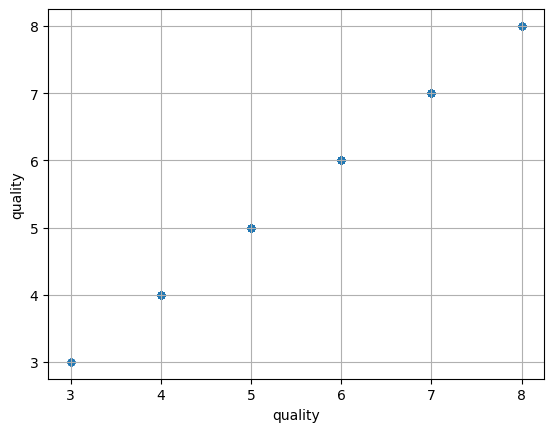

In [27]:
col_count = len(num_columns)

# plt.subplots(figsize = (10, 50))

for idx, col in enumerate(num_columns):
    # plt.subplot(12, 1, idx + 1)
    wine.plot(kind='scatter', x=col, y='quality')
    plt.grid(True)
    plt.show()

# plt.tight_layout()
# plt.show()

# 데이터 분할 및 RandomForest 테스트

In [126]:
from sklearn.model_selection import train_test_split

x = wine.drop(['quality'], axis=1)
y = wine['quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify = y)

In [127]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=1/(1+8), stratify = y_train)

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forests = []
for e_tree in range(1, 51) :
    forest = RandomForestClassifier(n_estimators=e_tree, max_depth=15, min_samples_leaf=5)
    forest.fit(x_train, y_train)
    forests.append(forest)

In [129]:
accs = []
for i in range(50) :
    forest = forests[i]
    acc = forest.score(x_valid, y_valid)
    accs.append(acc)

20 0.7125


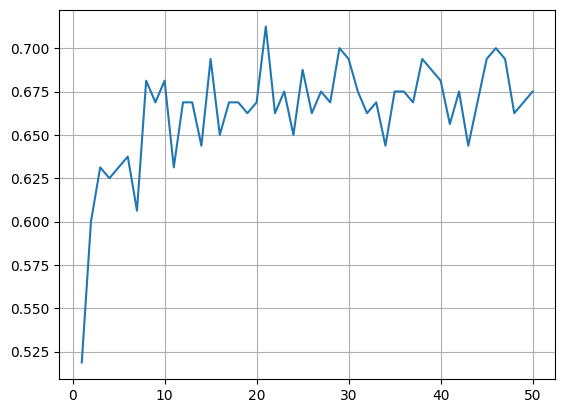

In [130]:
import numpy as np
max_idx = np.argmax(accs)
max_acc = accs[max_idx]
print(max_idx, max_acc)

plt.plot([i for i in range(1, 51)], accs)
plt.grid(True)
plt.show()

In [131]:
forest = forests[max_idx]
print(forest.feature_importances_)

[0.06210823 0.10323055 0.06843271 0.04892579 0.06336587 0.05011885
 0.11821543 0.08291791 0.06642818 0.13592785 0.20032864]


In [132]:
# important_columns = ['alcohol', 'sulphates', 'volatile acidity', 'total sulfur dioxide']

# x = wine.loc[:, important_columns]
x = wine.drop(['quality'], axis=1)
y = wine['quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify = y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=1/(1+8), stratify = y_train)

In [157]:
forest = RandomForestClassifier(n_estimators=20, max_depth=15, min_samples_leaf=5)
forest.fit(x_train, y_train)
acc = forest.score(x_valid, y_valid)
print(acc, forest.feature_importances_)

0.675 [0.04257232 0.08732079 0.04967031 0.0586599  0.07715014 0.04938095
 0.10199666 0.07628305 0.05165907 0.11851689 0.15049274 0.01828341
 0.05906706 0.00605402 0.05289268]


# 딥러닝 사용하기

In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

In [159]:
wine2 = wine.copy()

def get_alcohol_level(row):
    if row['density'] > 0.997 and row['alcohol'] >= 10:
        return 0
    elif row['alcohol'] >= 12 and row['volatile acidity'] < 0.4 and row['sulphates'] > 0.6:
        return 2
    else:
        return 1

wine2['alcohol_level'] = wine2.apply(get_alcohol_level, axis=1)

wine2['acidity balance'] = wine2['fixed acidity'] + wine2['citric acid'] - wine2['volatile acidity']
wine2['balance'] = wine2.apply(lambda row: 1 if (3.1 < row['pH'] < 3.6 and row['acidity balance'] > 7) else 0, axis=1)
wine2['sweet alcohol ratio'] = wine2['residual sugar'] / wine2['alcohol']
# wine2['freshness'] = wine2['free sulfur dioxide'] * wine2['total sulfur dioxide']

In [90]:
wine2.loc[wine2['quality'] == 3]['freshness'].mean()

np.float64(392.1)

In [160]:
x = wine2.drop(['quality'], axis=1)
y = wine2['quality']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify = y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=1/(1+8), stratify = y_train)

In [66]:
x_train.shape

(1279, 12)

In [161]:
keras.backend.clear_session()

input_size = x_train.shape[1]

model = Sequential()
model.add(Dense(36, activation='relu', input_shape=(input_size,)))
model.add(BatchNormalization())
model.add(Dense(36, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=2000, batch_size=32,
                    verbose=1,validation_data=(x_valid, y_valid),callbacks=[es])

Epoch 1/2000


D:\workspace\repository\Lab\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1315 - loss: 2.6151 - val_accuracy: 0.0688 - val_loss: 2.8205
Epoch 2/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4481 - loss: 1.9840 - val_accuracy: 0.2937 - val_loss: 2.3103
Epoch 3/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5277 - loss: 1.7243 - val_accuracy: 0.4375 - val_loss: 2.0544
Epoch 4/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5561 - loss: 1.5543 - val_accuracy: 0.4688 - val_loss: 1.8414
Epoch 5/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5479 - loss: 1.4621 - val_accuracy: 0.4688 - val_loss: 1.5908
Epoch 6/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5993 - loss: 1.2773 - val_accuracy: 0.4812 - val_loss: 1.4536
Epoch 7/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5883 - loss: 1.2324 - val_accuracy: 0.4563 - val_loss: 1.3031
Epoch 8/2000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5859 - loss: 1.1457 - val_accuracy: 0.4625 - val_l

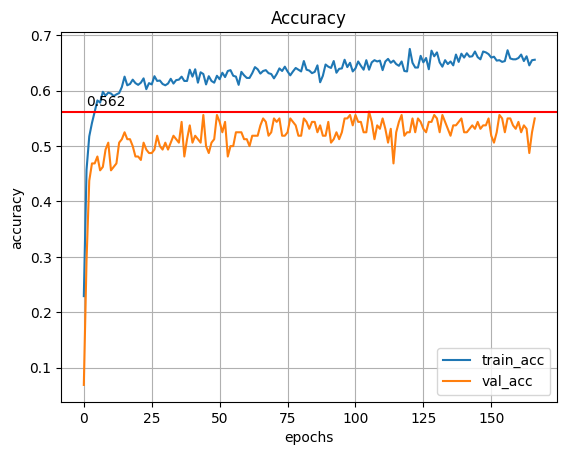

In [162]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_acc', 'val_acc'])
plt.axhline(max(history.history['val_accuracy']), color='r')
plt.text(1, max(history.history['val_accuracy']) + 0.01, round(max(history.history['val_accuracy']), 3))
plt.grid(True)
plt.show()